In [13]:
from langgraph.graph import StateGraph, START , END
from dotenv import load_dotenv
load_dotenv()
from typing import TypedDict,Optional, Annotated,List
from  langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from  langchain_core.prompts import PromptTemplate

In [14]:
class ReviewState(TypedDict):
    text : str
    sentiment : Annotated[str,'sentiment of user negative or positive']
    replyText : str
    diagnosis : str


In [15]:
graph = StateGraph(ReviewState)

In [16]:
llm = HuggingFaceEndpoint(model="meta-llama/Meta-Llama-3-8B-Instruct",task="text-generation")
model = ChatHuggingFace(llm=llm)

In [17]:
def checkReview(state:ReviewState)->ReviewState:
    print("Current state:", state)

    prompt = PromptTemplate(template="""You are a sentiment teller you will only reply in 'negative' or 'positive' from this text : {text}""", input_variables=['text'],validate_template=True)
    prompt = prompt.invoke({
        'text':state['text']
    })
    result = model.invoke(prompt)
    if type(result.content) == str:
        state['sentiment'] = result.content
    return state

In [18]:
def reply_Positive_response(state:ReviewState)->ReviewState:
    print("Current state:", state)

    prompt = PromptTemplate(template="""You are a bot which re
                            plies like thank you for using our serivce see this text and repliy it : {text}""", input_variables=['text'],validate_template=True)
    prompt = prompt.invoke({
        'text':state['text']
    })
    result = model.invoke(prompt)
    if type(result.content) == str:
        state['replyText'] = result.content
    return state


In [19]:
def run_diagnosis(state:ReviewState)->ReviewState:
    print("Current state:", state)

    prompt = PromptTemplate(template="""Can you take things like what is the problem why user doesnt like our service, what start he gave us , the name of user : {text}""", input_variables=['text'],validate_template=True)
    prompt = prompt.invoke({
        'text':state['text']
    })
    result = model.invoke(prompt)
    print(result.content)
    if type(result.content) == str:
        
        state['diagnosis'] = f'{result.content}'
    return state


In [20]:
from typing import Literal

def cond_node(state: ReviewState) -> Literal['reply_Positive_response','run_diagnosis']:
    if state['sentiment'].strip().lower() == 'positive':
        return 'reply_Positive_response'
    else:
        return 'run_diagnosis'


In [21]:
graph.add_node('checkReview',checkReview)
graph.add_node('reply_Positive_response',reply_Positive_response)
graph.add_node('run_diagnosis',run_diagnosis)

graph.add_edge(START,'checkReview')

graph.add_conditional_edges('checkReview', cond_node,
    {
        'reply_Positive_response': 'reply_Positive_response',
        'run_diagnosis': 'run_diagnosis'
    })

graph.add_edge('reply_Positive_response',END)
graph.add_edge('run_diagnosis',END)




In [22]:
workflow = graph.compile()

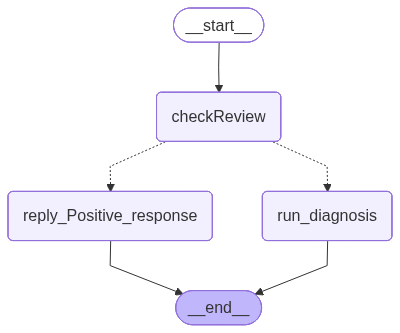

In [23]:
workflow

In [24]:
# workflow.invoke({'text':"Rahul Sharma, 2 stars: I was really disappointed with the service. The staff were unresponsive, and my issue wasn’t resolved even after multiple requests. Overall, I’m not satisfied with the experience and expected much better support."})
workflow.invoke({'text':"Anita Verma, 5 stars: I had an amazing experience with the customer service team! They were prompt, courteous, and resolved my issue quickly. I’m very satisfied with the support I received and would highly recommend their service to others."})

Current state: {'text': 'Anita Verma, 5 stars: I had an amazing experience with the customer service team! They were prompt, courteous, and resolved my issue quickly. I’m very satisfied with the support I received and would highly recommend their service to others.'}
Current state: {'text': 'Anita Verma, 5 stars: I had an amazing experience with the customer service team! They were prompt, courteous, and resolved my issue quickly. I’m very satisfied with the support I received and would highly recommend their service to others.', 'sentiment': 'Positive'}


{'text': 'Anita Verma, 5 stars: I had an amazing experience with the customer service team! They were prompt, courteous, and resolved my issue quickly. I’m very satisfied with the support I received and would highly recommend their service to others.',
 'sentiment': 'Positive',
 'replyText': "Thank you for using our service. Here's the text you provided with a possible reply:\n\nAnita Verma, 5 stars: I had an amazing experience with the customer service team! They were prompt, courteous, and resolved my issue quickly. I’m very satisfied with the support I received and would highly recommend their service to others.\n\nOur team at [Company Name] is thrilled to have provided you with an exceptional experience. We strive to deliver prompt and courteous support, and it's great to know that we met your expectations. Thank you for taking the time to share your feedback, and we're glad to have you as a valued customer."}